In [4]:
from climada.hazard.base import Hazard
from climada.hazard.low_flow import LowFlow
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import fiona
import datetime
import geopandas as gpd
from climada.util.coordinates import dist_to_coast

In [5]:
wri_power_plants_path = 'power_plants_wri/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [ ]:
nuclear_exp = load_exposure(primary_fuel='Nuclear')
coal_exp = load_exposure(primary_fuel='Coal')
gas_exp = load_exposure(primary_fuel='Gas')
hydro_exp = load_exposure(primary_fuel='Hydro')

## Getting rid of exposures far from rivers and to close to the coast

In [10]:
# this data is built ith different layers from quantiles of river size, the following files were
# needed to reach a sufficient level of detail
# https://www.bafg.de/GRDC/EN/Home/homepage_node.html

rivers1 = gpd.read_file('rivers/mrb_rivnets_Q09_10.shp')
rivers2 = gpd.read_file('rivers/mrb_rivnets_Q08_09.shp')
rivers3 = gpd.read_file('rivers/mrb_rivnets_Q07_08.shp')
rivers4 = gpd.read_file('rivers/mrb_rivnets_Q06_07.shp')


In [11]:
rivers1.head()

,RIVER_BASI,CONTINENT,OCEAN,SEA,AREA_CALC,Shape_Leng,MRBID,geometry
0,ATOUI,Africa,Atlantic Ocean,North Atlantic,27695.3,4.092204,1201,LINESTRING (-14.00208333333333 22.202083333332...
1,BANDAMA,Africa,Atlantic Ocean,Gulf of Guinea,99253.9,13.885620,1202,(LINESTRING (-4.827083333333519 5.947916666666...
2,BIA,Africa,Atlantic Ocean,Gulf of Guinea,10957.0,1.051965,1203,LINESTRING (-3.227083333333525 6.0187499999993...
3,CAVALLY,Africa,Atlantic Ocean,Gulf of Guinea,29622.7,3.372281,1204,LINESTRING (-7.943750000000165 6.2979166666660...
4,CESTOS (also NUON),Africa,Atlantic Ocean,North Atlantic,12785.1,1.435313,1205,LINESTRING (-8.839583333333422 6.0979166666660...


In [12]:
def min_distance(point, lines):
    return lines.distance(point).min()

n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    nuclear_exp["".join(['min_dist_to_lines',str(n)])] = nuclear_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

nuclear_exp['min_dist_to_lines']=nuclear_exp.iloc[:,29:].min(axis=1)
nuclear_close_to_rivers = nuclear_exp[(nuclear_exp['min_dist_to_lines']<0.1)]


In [13]:
nuclear_close_to_rivers = nuclear_close_to_rivers.drop(nuclear_close_to_rivers.columns[29:], axis=1)

In [14]:
nuclear_close_to_rivers = Exposures(nuclear_close_to_rivers)
nuclear_close_to_rivers.crs = {'init': 'epsg:4326'}
nuclear_close_to_rivers['dist_to_coast'] = dist_to_coast(nuclear_close_to_rivers) #get the distance to coast 
nuclear_close_to_rivers = nuclear_close_to_rivers[nuclear_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

2020-07-02 11:07:53,565 - climada.util.coordinates - INFO - dist_to_coast: UTM 32611 (1/96)
2020-07-02 11:07:53,982 - climada.util.coordinates - INFO - dist_to_coast: UTM 32612 (3/96)
2020-07-02 11:07:54,367 - climada.util.coordinates - INFO - dist_to_coast: UTM 32614 (7/96)
2020-07-02 11:07:54,881 - climada.util.coordinates - INFO - dist_to_coast: UTM 32615 (9/96)
2020-07-02 11:07:55,776 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (11/96)
2020-07-02 11:07:56,626 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (13/96)
2020-07-02 11:07:57,553 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (15/96)
2020-07-02 11:07:58,603 - climada.util.coordinates - INFO - dist_to_coast: UTM 32619 (17/96)
2020-07-02 11:07:59,564 - climada.util.coordinates - INFO - dist_to_coast: UTM 32720 (20/96)
2020-07-02 11:07:59,821 - climada.util.coordinates - INFO - dist_to_coast: UTM 32721 (22/96)
2020-07-02 11:08:00,226 - climada.util.coordinates - INFO - dist_to_coast:

In [15]:
len(nuclear_close_to_rivers)/len(nuclear_exp)

0.5353535353535354

Text(0.5, 1, 'Nuclear Power Plants')

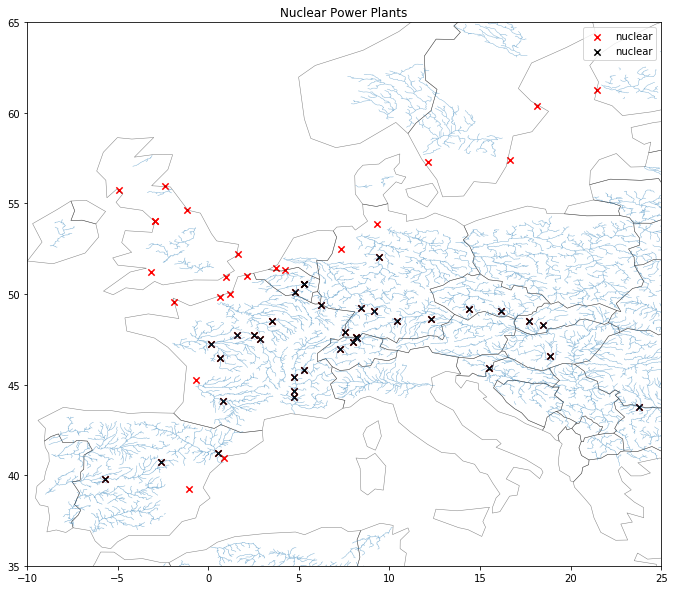

In [16]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='nuclear',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='nuclear',marker='x',color='Black')

ax.legend()
ax.set_xlim(-10, 25)
ax.set_ylim(35, 65)
ax.set_title('Nuclear Power Plants')


Text(0.5, 1, 'Nuclear Power Plants')

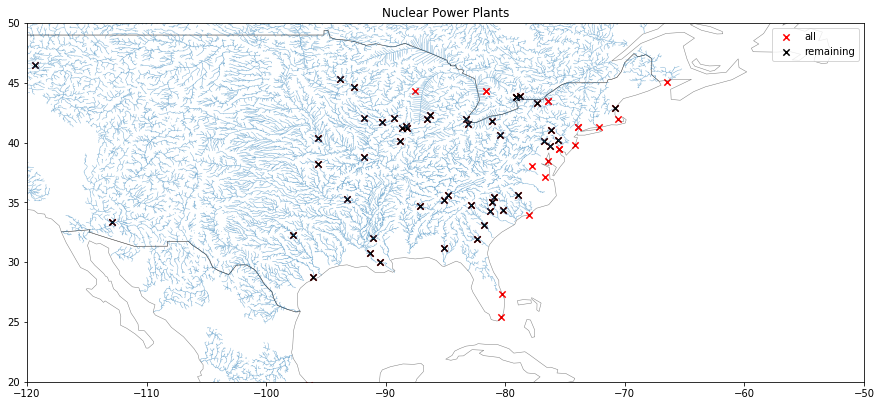

In [17]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#gas_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='gas')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Nuclear Power Plants')


In [ ]:
n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    gas_exp["".join(['min_dist_to_lines',str(n)])] = gas_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

gas_exp['min_dist_to_lines']=gas_exp.iloc[:,29:].min(axis=1)
gas_close_to_rivers = gas_exp[(gas_exp['min_dist_to_lines']<0.1)]
gas_close_to_rivers = gas_close_to_rivers.drop(gas_close_to_rivers.columns[29:], axis=1)
gas_close_to_rivers = Exposures(gas_close_to_rivers)
gas_close_to_rivers.crs = {'init': 'epsg:4326'}
gas_close_to_rivers['dist_to_coast'] = dist_to_coast(gas_close_to_rivers) #get the distance to coast 
gas_close_to_rivers = gas_close_to_rivers[gas_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

Text(0.5, 1, 'Gas Power Plants')

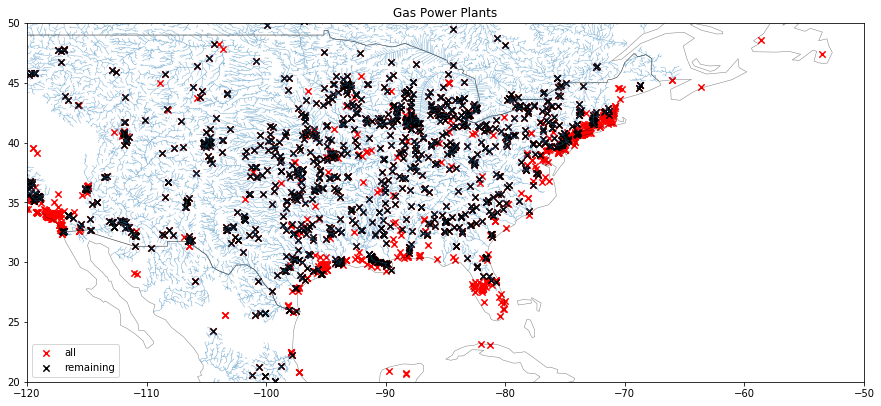

In [19]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#gas_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='gas')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
gas_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
gas_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Gas Power Plants')

In [ ]:
n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    coal_exp["".join(['min_dist_to_lines',str(n)])] = coal_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

coal_exp['min_dist_to_lines']=coal_exp.iloc[:,29:].min(axis=1)
coal_close_to_rivers = coal_exp[(coal_exp['min_dist_to_lines']<0.1)]
coal_close_to_rivers = coal_close_to_rivers.drop(coal_close_to_rivers.columns[29:], axis=1)
coal_close_to_rivers = Exposures(coal_close_to_rivers)
coal_close_to_rivers.crs = {'init': 'epsg:4326'}
coal_close_to_rivers['dist_to_coast'] = dist_to_coast(coal_close_to_rivers) #get the distance to coast 
coal_close_to_rivers = coal_close_to_rivers[coal_close_to_rivers['dist_to_coast']>1000] # dist to coast is in meters

Text(0.5, 1, 'Coal Power Plants')

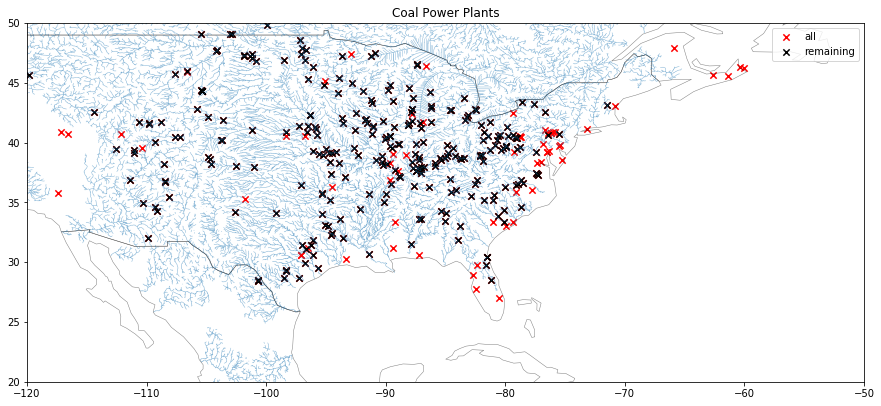

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#coal_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='coal')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
coal_exp.plot(ax=ax,color='Red',markersize=40,label='all',marker='x')
coal_close_to_rivers.plot(ax=ax,markersize=40,label='remaining',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)
ax.set_title('Coal Power Plants')

### what portion of gas pp are close to rivers in israel?

In [22]:
len(gas_close_to_rivers[gas_close_to_rivers['country_long']=='Israel'])/len(gas_exp[gas_exp['country_long']=='Israel'])

0.05555555555555555

In [23]:
len(gas_exp[gas_exp['country_long']=='Israel'])

18

In [ ]:
coal_close_to_rivers.to_excel('coal_exposures.xlsx')
gas_close_to_rivers.to_excel('gas_exposures.xlsx')
nuclear_close_to_rivers.to_excel('nuclear_exposures.xlsx')
hydro_exp.to_excel('hydro_exposures.xlsx')